In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
import pandas as pd

df = pd.read_excel('Data/Data.xlsx', sheet_name=1, header=None, skiprows=1)

feature_vector = df.iloc[0:1086, :]

additional_features = df.iloc[1087:1099, :]

feature_vector.reset_index(drop=True, inplace=True)
additional_features.reset_index(drop=True, inplace=True)


feature_vector_T = feature_vector.transpose()
additional_features_T = additional_features.transpose()

full_data = pd.concat([feature_vector_T, additional_features_T], axis=1)

full_data.reset_index(drop=True, inplace=True)


df = full_data
df = df.drop(0, axis=0)
df
df.to_csv('output.csv', index=False)

import pandas as pd

df = pd.read_excel('Data/Data.xlsx', sheet_name=1, header=None, skiprows=1)

feature_vector = df.iloc[0:1086, :]

additional_features = df.iloc[1087:1099, :]

feature_vector.reset_index(drop=True, inplace=True)
additional_features.reset_index(drop=True, inplace=True)


feature_vector_T = feature_vector.transpose()
additional_features_T = additional_features.transpose()

full_data = pd.concat([feature_vector_T, additional_features_T], axis=1)

full_data.reset_index(drop=True, inplace=True)


df = full_data
df = df.drop(0, axis=0)
df
df.to_csv('output.csv', index=False)


new_header = df.iloc[0]
df = df[1:]
df.columns = new_header

# Reset index for the final DataFrame
df.reset_index(drop=True, inplace=True)

df.head()

pd.set_option('display.max_columns', None)  

df = df[~df.isin(['x']).any(axis=1)]

one_hot_encoded_data = pd.get_dummies(df, columns = ['Digester', 'Source', 'Type', 'Waste', 'Biomass']).astype(int)
# print(one_hot_encoded_data)
df_use = one_hot_encoded_data


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader

# Load dataset from DataFrame
def prepare_data(df, target_column):
    X = df.drop(columns=[target_column]).values
    y = df[target_column].values
    return X, y

# Define a custom dataset
class MicrobialDataset(Dataset):
    def __init__(self, df, target_column):
        X, y = prepare_data(df, target_column)
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Define the Transformer-based regression model
class TransformerRegressionModel(nn.Module):
    def __init__(self, input_dim, d_model=128, nhead=8, num_layers=4, dim_feedforward=256, dropout=0.1):
        super(TransformerRegressionModel, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        self.regressor = nn.Linear(d_model, 1)  # Output is a single continuous value

    def forward(self, x):
        x = self.embedding(x).unsqueeze(1)  # Add sequence dimension
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)  # Global average pooling
        return self.regressor(x).squeeze()

# Function to train the model
def train_model(model, train_loader, criterion, optimizer, device, epochs=50):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}")

# Function to evaluate the model
def evaluate_model(model, test_loader, device):
    model.eval()
    mse_loss = nn.MSELoss()
    total_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            predictions = model(X_batch)
            loss = mse_loss(predictions, y_batch)
            total_loss += loss.item()
    print(f"Test MSE Loss: {total_loss/len(test_loader):.4f}")

# Sample data (replace with your actual DataFrame)
df = pd.read_csv("Data/New_Data.csv")  # Load your dataset

target_column = "ACE-km"  # Define the target column
train_size = int(0.8 * len(df))
train_df = df_use[:train_size]
test_df = df_use[train_size:]

# Create datasets and data loaders
train_dataset = MicrobialDataset(train_df, target_column)
test_dataset = MicrobialDataset(test_df, target_column)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = train_df.shape[1] - 1  # Number of features
model = TransformerRegressionModel(input_dim=input_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train and evaluate
train_model(model, train_loader, criterion, optimizer, device, epochs=50)
evaluate_model(model, test_loader, device)


/Users/sb/miniforge3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/50], Loss: 249.5402
Epoch [2/50], Loss: 182.2895
Epoch [3/50], Loss: 171.2503
Epoch [4/50], Loss: 131.8796
Epoch [5/50], Loss: 171.4570
Epoch [6/50], Loss: 150.2130
Epoch [7/50], Loss: 164.2311
Epoch [8/50], Loss: 151.8343
Epoch [9/50], Loss: 152.8200
Epoch [10/50], Loss: 176.5534
Epoch [11/50], Loss: 153.3517
Epoch [12/50], Loss: 138.5383
Epoch [13/50], Loss: 155.9194
Epoch [14/50], Loss: 119.9991
Epoch [15/50], Loss: 129.6535
Epoch [16/50], Loss: 126.8164
Epoch [17/50], Loss: 144.9069
Epoch [18/50], Loss: 137.4190
Epoch [19/50], Loss: 127.4180
Epoch [20/50], Loss: 111.3035
Epoch [21/50], Loss: 120.6378
Epoch [22/50], Loss: 136.5822
Epoch [23/50], Loss: 125.1203
Epoch [24/50], Loss: 115.7630
Epoch [25/50], Loss: 128.2270
Epoch [26/50], Loss: 134.8051
Epoch [27/50], Loss: 103.0411
Epoch [28/50], Loss: 123.5336
Epoch [29/50], Loss: 137.4987
Epoch [30/50], Loss: 106.1658
Epoch [31/50], Loss: 108.5831
Epoch [32/50], Loss: 128.9393
Epoch [33/50], Loss: 122.4721
Epoch [34/50], Loss

Fold 1/5
Epoch [1/100], Loss: 281.5475
Epoch [2/100], Loss: 159.9949
Epoch [3/100], Loss: 155.1567
Epoch [4/100], Loss: 180.7167
Epoch [5/100], Loss: 141.3532
Epoch [6/100], Loss: 158.7788


/Users/sb/miniforge3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [7/100], Loss: 136.7491
Epoch [8/100], Loss: 176.2812
Epoch [9/100], Loss: 155.0311
Epoch [10/100], Loss: 131.1310
Epoch [11/100], Loss: 133.7276
Epoch [12/100], Loss: 121.7033
Epoch [13/100], Loss: 137.3551
Epoch [14/100], Loss: 147.6774
Epoch [15/100], Loss: 138.2336
Epoch [16/100], Loss: 139.8872
Epoch [17/100], Loss: 136.8064
Epoch [18/100], Loss: 122.7897
Epoch [19/100], Loss: 127.9385
Epoch [20/100], Loss: 130.4433
Epoch [21/100], Loss: 103.8529
Epoch [22/100], Loss: 124.1534
Epoch [23/100], Loss: 126.8371
Epoch [24/100], Loss: 112.1036
Epoch [25/100], Loss: 138.6825
Epoch [26/100], Loss: 108.5755
Epoch [27/100], Loss: 110.8191
Epoch [28/100], Loss: 108.3942
Epoch [29/100], Loss: 101.9399
Epoch [30/100], Loss: 109.0581
Epoch [31/100], Loss: 101.8074
Epoch [32/100], Loss: 110.5650
Epoch [33/100], Loss: 103.1993
Epoch [34/100], Loss: 107.6308
Epoch [35/100], Loss: 110.1733
Epoch [36/100], Loss: 135.3067
Epoch [37/100], Loss: 96.8806
Epoch [38/100], Loss: 111.8104
Epoch [39/10

/Users/sb/miniforge3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [11/100], Loss: 129.8762
Epoch [12/100], Loss: 122.6138
Epoch [13/100], Loss: 128.5089
Epoch [14/100], Loss: 117.5820
Epoch [15/100], Loss: 121.5552
Epoch [16/100], Loss: 148.1238
Epoch [17/100], Loss: 124.9741
Epoch [18/100], Loss: 117.4148
Epoch [19/100], Loss: 127.8965
Epoch [20/100], Loss: 126.3622
Epoch [21/100], Loss: 139.7056
Epoch [22/100], Loss: 116.5827
Epoch [23/100], Loss: 105.8260
Epoch [24/100], Loss: 117.5020
Epoch [25/100], Loss: 109.0113
Epoch [26/100], Loss: 119.7402
Epoch [27/100], Loss: 112.2488
Epoch [28/100], Loss: 125.5976
Epoch [29/100], Loss: 128.6998
Epoch [30/100], Loss: 122.0792
Epoch [31/100], Loss: 120.5375
Epoch [32/100], Loss: 125.1584
Epoch [33/100], Loss: 115.6763
Epoch [34/100], Loss: 97.1447
Epoch [35/100], Loss: 123.3281
Epoch [36/100], Loss: 105.7068
Epoch [37/100], Loss: 100.8897
Epoch [38/100], Loss: 138.9979
Epoch [39/100], Loss: 104.7051
Epoch [40/100], Loss: 104.0602
Epoch [41/100], Loss: 104.7542
Epoch [42/100], Loss: 94.8986
Epoch [43/

/Users/sb/miniforge3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [3/100], Loss: 180.8612
Epoch [4/100], Loss: 189.5226
Epoch [5/100], Loss: 151.3642
Epoch [6/100], Loss: 175.8300
Epoch [7/100], Loss: 159.2956
Epoch [8/100], Loss: 155.4528
Epoch [9/100], Loss: 151.5444
Epoch [10/100], Loss: 167.1999
Epoch [11/100], Loss: 163.2920
Epoch [12/100], Loss: 153.5844
Epoch [13/100], Loss: 147.1553
Epoch [14/100], Loss: 145.9043
Epoch [15/100], Loss: 147.5211
Epoch [16/100], Loss: 125.7564
Epoch [17/100], Loss: 167.7672
Epoch [18/100], Loss: 141.4666
Epoch [19/100], Loss: 123.3548
Epoch [20/100], Loss: 121.6511
Epoch [21/100], Loss: 109.2177
Epoch [22/100], Loss: 137.6969
Epoch [23/100], Loss: 133.3239
Epoch [24/100], Loss: 126.1217
Epoch [25/100], Loss: 106.2766
Epoch [26/100], Loss: 121.9240
Epoch [27/100], Loss: 104.6732
Epoch [28/100], Loss: 113.3492
Epoch [29/100], Loss: 109.3220
Epoch [30/100], Loss: 107.2739
Epoch [31/100], Loss: 136.8477
Epoch [32/100], Loss: 113.0776
Epoch [33/100], Loss: 113.6570
Epoch [34/100], Loss: 129.8570
Epoch [35/100],

/Users/sb/miniforge3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [8/100], Loss: 149.4232
Epoch [9/100], Loss: 121.8825
Epoch [10/100], Loss: 154.3839
Epoch [11/100], Loss: 147.7421
Epoch [12/100], Loss: 110.0813
Epoch [13/100], Loss: 120.9482
Epoch [14/100], Loss: 126.9263
Epoch [15/100], Loss: 132.0257
Epoch [16/100], Loss: 116.9163
Epoch [17/100], Loss: 138.8060
Epoch [18/100], Loss: 100.3156
Epoch [19/100], Loss: 97.6611
Epoch [20/100], Loss: 126.5604
Epoch [21/100], Loss: 97.0615
Epoch [22/100], Loss: 122.8136
Epoch [23/100], Loss: 98.6165
Epoch [24/100], Loss: 86.7130
Epoch [25/100], Loss: 95.3744
Epoch [26/100], Loss: 86.0254
Epoch [27/100], Loss: 91.8325
Epoch [28/100], Loss: 89.7212
Epoch [29/100], Loss: 93.1206
Epoch [30/100], Loss: 112.4225
Epoch [31/100], Loss: 115.2435
Epoch [32/100], Loss: 99.2900
Epoch [33/100], Loss: 96.8714
Epoch [34/100], Loss: 110.7406
Epoch [35/100], Loss: 96.7065
Epoch [36/100], Loss: 107.8822
Epoch [37/100], Loss: 92.4883
Epoch [38/100], Loss: 79.9064
Epoch [39/100], Loss: 88.9243
Epoch [40/100], Loss: 96.

/Users/sb/miniforge3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [12/100], Loss: 97.1739
Epoch [13/100], Loss: 89.5895
Epoch [14/100], Loss: 96.6444
Epoch [15/100], Loss: 90.8518
Epoch [16/100], Loss: 82.6501
Epoch [17/100], Loss: 88.5269
Epoch [18/100], Loss: 88.9935
Epoch [19/100], Loss: 101.4469
Epoch [20/100], Loss: 90.4097
Epoch [21/100], Loss: 102.7022
Epoch [22/100], Loss: 78.6503
Epoch [23/100], Loss: 92.9789
Epoch [24/100], Loss: 93.9383
Epoch [25/100], Loss: 82.1112
Epoch [26/100], Loss: 89.1133
Epoch [27/100], Loss: 84.0437
Epoch [28/100], Loss: 80.8347
Epoch [29/100], Loss: 78.7375
Epoch [30/100], Loss: 81.6589
Epoch [31/100], Loss: 86.1029
Epoch [32/100], Loss: 77.7121
Epoch [33/100], Loss: 78.1167
Epoch [34/100], Loss: 85.2349
Epoch [35/100], Loss: 94.4432
Epoch [36/100], Loss: 78.8331
Epoch [37/100], Loss: 83.6496
Epoch [38/100], Loss: 76.5857
Epoch [39/100], Loss: 96.4681
Epoch [40/100], Loss: 89.3009
Epoch [41/100], Loss: 85.3702
Epoch [42/100], Loss: 88.0924
Epoch [43/100], Loss: 78.3618
Epoch [44/100], Loss: 80.1862
Epoch [4

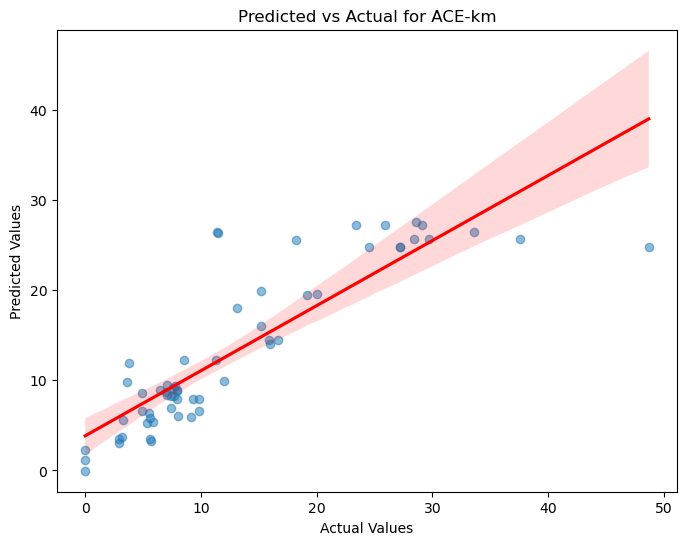

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

# List of target columns
target_columns = [
    "Average-Total-ISD-Cells", "ACE-Xi", "ACE-km", "ACE-Ks", "H2-Xi", "H2-km", "H2-Ks",
    "Digester_BD", "Digester_BF", "Digester_CB", "Digester_CP", "Digester_FD", "Digester_GB",
    "Digester_GP", "Digester_JB", "Digester_LP", "Digester_MA", "Digester_NB", "Digester_NS",
    "Digester_PC", "Digester_PO", "Digester_SF", "Digester_SS", "Digester_SW", "Digester_WA",
    "Digester_WP", "Digester_WR", "Source_I", "Source_M", "Source_P", "Type_CSTR", "Type_EFB",
    "Type_EGSB", "Type_Lagoon", "Type_UASB", "Waste_BW", "Waste_Dairy", "Waste_FW", "Waste_HSI",
    "Waste_MPW", "Waste_MS", "Waste_MS+Dairy", "Waste_MS+HSI", "Waste_PP", "Waste_PR",
    "Waste_SDW", "Biomass_F", "Biomass_G"
]

# Load dataset from DataFrame
def prepare_data(df, target_column):
    df = df.dropna()
    df = df.apply(pd.to_numeric, errors='coerce').fillna(0)
    X = df.drop(columns=target_columns).values.astype(np.float32)
    y = df[target_column].values.astype(np.float32)
    return X, y

# Define a custom dataset
class MicrobialDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Define the Transformer-based regression model
class TransformerRegressionModel(nn.Module):
    def __init__(self, input_dim, d_model=128, nhead=8, num_layers=4, dim_feedforward=256, dropout=0.1):
        super(TransformerRegressionModel, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        self.regressor = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.embedding(x).unsqueeze(1)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        return self.regressor(x).squeeze()

# Cross-validation function
def cross_validate(df, target_column, k_folds=5, epochs=100):
    X, y = prepare_data(df, target_column)
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    mse_scores, r2_scores = [], []
    all_actuals, all_predictions = [], []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        print(f"Fold {fold+1}/{k_folds}")
        
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        train_dataset = MicrobialDataset(X_train, y_train)
        val_dataset = MicrobialDataset(X_val, y_val)
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
        
        input_dim = X_train.shape[1]
        model = TransformerRegressionModel(input_dim=input_dim).to(device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        model.train()
        for epoch in range(epochs):
            total_loss = 0
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                optimizer.zero_grad()
                predictions = model(X_batch)
                loss = criterion(predictions, y_batch)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}")
        
        model.eval()
        val_preds, val_actuals = [], []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                predictions = model(X_batch).cpu().numpy()
                val_preds.extend(predictions)
                val_actuals.extend(y_batch.cpu().numpy())
        
        mse = mean_squared_error(val_actuals, val_preds)
        r2 = r2_score(val_actuals, val_preds)
        mse_scores.append(mse)
        r2_scores.append(r2)
        
        all_actuals.extend(val_actuals)
        all_predictions.extend(val_preds)
        print(f"Fold {fold+1}: MSE = {mse:.4f}, R^2 = {r2:.4f}")
    
    print(f"Final Cross-Validation Results: MSE = {np.mean(mse_scores):.4f}, R^2 = {np.mean(r2_scores):.4f}")
    
    # Scatter plot with line of best fit
    plt.figure(figsize=(8, 6))
    sns.regplot(x=all_actuals, y=all_predictions, scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"Predicted vs Actual for {target_column}")
    plt.show()

# Load dataset
df = pd.read_csv("Data/New_data.csv")

# Perform cross-validation for a target column
target_column = "ACE-km"
cross_validate(df, target_column)


Fold 1/5
Epoch [1/100], Loss: 238.2786
Epoch [2/100], Loss: 169.1809
Epoch [3/100], Loss: 184.4600
Epoch [4/100], Loss: 163.6804
Epoch [5/100], Loss: 151.7298
Epoch [6/100], Loss: 146.4829
Epoch [7/100], Loss: 165.6030
Epoch [8/100], Loss: 154.9641
Epoch [9/100], Loss: 116.5766
Epoch [10/100], Loss: 150.1086


/Users/sb/miniforge3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [11/100], Loss: 177.8302
Epoch [12/100], Loss: 125.3276
Epoch [13/100], Loss: 144.5401
Epoch [14/100], Loss: 156.5723
Epoch [15/100], Loss: 127.0285
Epoch [16/100], Loss: 153.6550
Epoch [17/100], Loss: 138.6663
Epoch [18/100], Loss: 137.7980
Epoch [19/100], Loss: 138.6865
Epoch [20/100], Loss: 152.3131
Epoch [21/100], Loss: 121.4910
Epoch [22/100], Loss: 109.7403
Epoch [23/100], Loss: 136.5576
Epoch [24/100], Loss: 111.9325
Epoch [25/100], Loss: 132.2966
Epoch [26/100], Loss: 122.5877
Epoch [27/100], Loss: 130.5868
Epoch [28/100], Loss: 128.5789
Epoch [29/100], Loss: 132.2475
Epoch [30/100], Loss: 109.3085
Epoch [31/100], Loss: 122.8684
Epoch [32/100], Loss: 101.4562
Epoch [33/100], Loss: 116.0082
Epoch [34/100], Loss: 123.1167
Epoch [35/100], Loss: 112.8298
Epoch [36/100], Loss: 108.8824
Epoch [37/100], Loss: 117.5599
Epoch [38/100], Loss: 106.5300
Epoch [39/100], Loss: 115.3471
Epoch [40/100], Loss: 106.9404
Epoch [41/100], Loss: 133.7758
Epoch [42/100], Loss: 130.0946
Epoch [4

/Users/sb/miniforge3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [7/100], Loss: 169.5875
Epoch [8/100], Loss: 124.5226
Epoch [9/100], Loss: 134.7316
Epoch [10/100], Loss: 160.6457
Epoch [11/100], Loss: 127.8248
Epoch [12/100], Loss: 149.6157
Epoch [13/100], Loss: 106.3198
Epoch [14/100], Loss: 128.5958
Epoch [15/100], Loss: 121.5677
Epoch [16/100], Loss: 148.0456
Epoch [17/100], Loss: 116.5908
Epoch [18/100], Loss: 111.0045
Epoch [19/100], Loss: 116.1016
Epoch [20/100], Loss: 124.6410
Epoch [21/100], Loss: 120.7796
Epoch [22/100], Loss: 109.4841
Epoch [23/100], Loss: 122.8428
Epoch [24/100], Loss: 103.8637
Epoch [25/100], Loss: 116.4005
Epoch [26/100], Loss: 104.3111
Epoch [27/100], Loss: 129.5189
Epoch [28/100], Loss: 123.9738
Epoch [29/100], Loss: 106.5469
Epoch [30/100], Loss: 103.4571
Epoch [31/100], Loss: 118.1911
Epoch [32/100], Loss: 89.2322
Epoch [33/100], Loss: 116.4855
Epoch [34/100], Loss: 87.3908
Epoch [35/100], Loss: 96.2158
Epoch [36/100], Loss: 97.3369
Epoch [37/100], Loss: 94.5330
Epoch [38/100], Loss: 87.0967
Epoch [39/100], L

/Users/sb/miniforge3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [8/100], Loss: 146.7071
Epoch [9/100], Loss: 150.2779
Epoch [10/100], Loss: 135.8591
Epoch [11/100], Loss: 147.4140
Epoch [12/100], Loss: 135.5543
Epoch [13/100], Loss: 154.1634
Epoch [14/100], Loss: 121.1714
Epoch [15/100], Loss: 116.2016
Epoch [16/100], Loss: 128.3818
Epoch [17/100], Loss: 122.3728
Epoch [18/100], Loss: 132.3987
Epoch [19/100], Loss: 151.4215
Epoch [20/100], Loss: 113.3835
Epoch [21/100], Loss: 134.0097
Epoch [22/100], Loss: 135.7180
Epoch [23/100], Loss: 129.0506
Epoch [24/100], Loss: 119.6333
Epoch [25/100], Loss: 135.2792
Epoch [26/100], Loss: 104.3027
Epoch [27/100], Loss: 111.3158
Epoch [28/100], Loss: 121.8571
Epoch [29/100], Loss: 107.5517
Epoch [30/100], Loss: 113.1316
Epoch [31/100], Loss: 123.6372
Epoch [32/100], Loss: 137.9787
Epoch [33/100], Loss: 107.1770
Epoch [34/100], Loss: 106.3064
Epoch [35/100], Loss: 136.8722
Epoch [36/100], Loss: 115.4805
Epoch [37/100], Loss: 136.3201
Epoch [38/100], Loss: 111.6697
Epoch [39/100], Loss: 99.6008
Epoch [40/1

/Users/sb/miniforge3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [2/100], Loss: 144.5953
Epoch [3/100], Loss: 156.5597
Epoch [4/100], Loss: 138.2310
Epoch [5/100], Loss: 114.0622
Epoch [6/100], Loss: 114.5107
Epoch [7/100], Loss: 148.4585
Epoch [8/100], Loss: 143.8513
Epoch [9/100], Loss: 127.9861
Epoch [10/100], Loss: 111.8543
Epoch [11/100], Loss: 140.4861
Epoch [12/100], Loss: 135.3399
Epoch [13/100], Loss: 132.3668
Epoch [14/100], Loss: 102.0560
Epoch [15/100], Loss: 98.9891
Epoch [16/100], Loss: 131.1198
Epoch [17/100], Loss: 126.7894
Epoch [18/100], Loss: 99.1103
Epoch [19/100], Loss: 113.4575
Epoch [20/100], Loss: 134.6061
Epoch [21/100], Loss: 87.3645
Epoch [22/100], Loss: 89.5563
Epoch [23/100], Loss: 96.7445
Epoch [24/100], Loss: 113.1453
Epoch [25/100], Loss: 87.5937
Epoch [26/100], Loss: 93.7930
Epoch [27/100], Loss: 94.5150
Epoch [28/100], Loss: 117.6349
Epoch [29/100], Loss: 93.7797
Epoch [30/100], Loss: 90.7756
Epoch [31/100], Loss: 89.2640
Epoch [32/100], Loss: 88.2276
Epoch [33/100], Loss: 90.4361
Epoch [34/100], Loss: 89.8293

/Users/sb/miniforge3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [10/100], Loss: 100.9367
Epoch [11/100], Loss: 96.5197
Epoch [12/100], Loss: 118.1196
Epoch [13/100], Loss: 90.9772
Epoch [14/100], Loss: 108.6818
Epoch [15/100], Loss: 89.9468
Epoch [16/100], Loss: 94.0108
Epoch [17/100], Loss: 104.3791
Epoch [18/100], Loss: 86.3713
Epoch [19/100], Loss: 92.4080
Epoch [20/100], Loss: 91.0579
Epoch [21/100], Loss: 100.1344
Epoch [22/100], Loss: 82.8935
Epoch [23/100], Loss: 90.0825
Epoch [24/100], Loss: 78.7442
Epoch [25/100], Loss: 76.8031
Epoch [26/100], Loss: 76.0462
Epoch [27/100], Loss: 106.3921
Epoch [28/100], Loss: 93.3103
Epoch [29/100], Loss: 92.4289
Epoch [30/100], Loss: 87.5206
Epoch [31/100], Loss: 77.5486
Epoch [32/100], Loss: 93.8975
Epoch [33/100], Loss: 85.8946
Epoch [34/100], Loss: 86.1426
Epoch [35/100], Loss: 92.8108
Epoch [36/100], Loss: 95.0034
Epoch [37/100], Loss: 88.4009
Epoch [38/100], Loss: 89.5906
Epoch [39/100], Loss: 75.3094
Epoch [40/100], Loss: 81.6892
Epoch [41/100], Loss: 75.0541
Epoch [42/100], Loss: 83.1178
Epoc

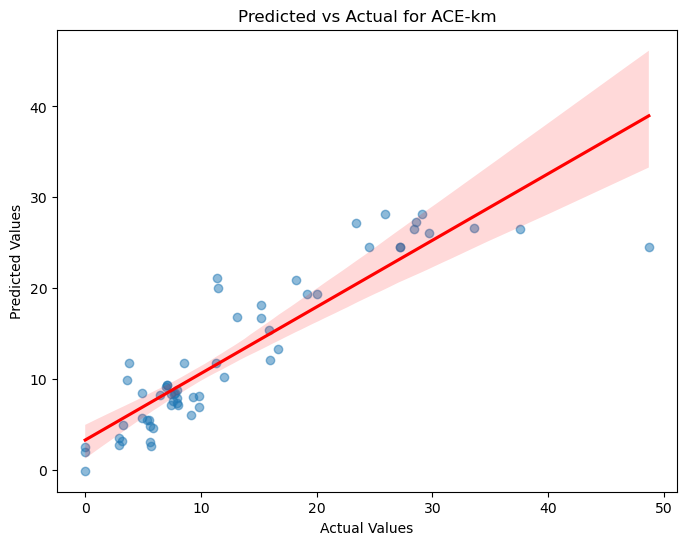

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

# List of target columns
target_columns = [
    "Average-Total-ISD-Cells", "ACE-Xi", "ACE-km", "ACE-Ks", "H2-Xi", "H2-km", "H2-Ks",
    "Digester_BD", "Digester_BF", "Digester_CB", "Digester_CP", "Digester_FD", "Digester_GB",
    "Digester_GP", "Digester_JB", "Digester_LP", "Digester_MA", "Digester_NB", "Digester_NS",
    "Digester_PC", "Digester_PO", "Digester_SF", "Digester_SS", "Digester_SW", "Digester_WA",
    "Digester_WP", "Digester_WR", "Source_I", "Source_M", "Source_P", "Type_CSTR", "Type_EFB",
    "Type_EGSB", "Type_Lagoon", "Type_UASB", "Waste_BW", "Waste_Dairy", "Waste_FW", "Waste_HSI",
    "Waste_MPW", "Waste_MS", "Waste_MS+Dairy", "Waste_MS+HSI", "Waste_PP", "Waste_PR",
    "Waste_SDW", "Biomass_F", "Biomass_G"
]

# Load dataset from DataFrame
def prepare_data(df, target_column):
    df = df.dropna()
    df = df.apply(pd.to_numeric, errors='coerce').fillna(0)
    X = df.drop(columns=target_columns).values.astype(np.float32)
    y = df[target_column].values.astype(np.float32)
    return X, y

# Define a custom dataset
class MicrobialDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Define the Transformer-based regression model
class TransformerRegressionModel(nn.Module):
    def __init__(self, input_dim, d_model=128, nhead=8, num_layers=4, dim_feedforward=256, dropout=0.1):
        super(TransformerRegressionModel, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        self.regressor = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.embedding(x).unsqueeze(1)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        return self.regressor(x).squeeze()

# Cross-validation function
def cross_validate(df, target_column, k_folds=5, epochs=100):
    X, y = prepare_data(df, target_column)
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    mse_scores, r2_scores = [], []
    all_actuals, all_predictions = [], []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        print(f"Fold {fold+1}/{k_folds}")
        
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        train_dataset = MicrobialDataset(X_train, y_train)
        val_dataset = MicrobialDataset(X_val, y_val)
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
        
        input_dim = X_train.shape[1]
        model = TransformerRegressionModel(input_dim=input_dim).to(device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        model.train()
        for epoch in range(epochs):
            total_loss = 0
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                optimizer.zero_grad()
                predictions = model(X_batch)
                loss = criterion(predictions, y_batch)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}")
        
        model.eval()
        val_preds, val_actuals = [], []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                predictions = model(X_batch).cpu().numpy()
                val_preds.extend(predictions)
                val_actuals.extend(y_batch.cpu().numpy())
        
        mse = mean_squared_error(val_actuals, val_preds)
        r2 = r2_score(val_actuals, val_preds)
        mse_scores.append(mse)
        r2_scores.append(r2)
        
        all_actuals.extend(val_actuals)
        all_predictions.extend(val_preds)
        print(f"Fold {fold+1}: MSE = {mse:.4f}, R^2 = {r2:.4f}")
    
    print(f"Final Cross-Validation Results: MSE = {np.mean(mse_scores):.4f}, R^2 = {np.mean(r2_scores):.4f}")
    
    # Scatter plot with line of best fit
    plt.figure(figsize=(8, 6))
    sns.regplot(x=all_actuals, y=all_predictions, scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"Predicted vs Actual for {target_column}")
    plt.show()

# Load dataset
df = pd.read_csv("Data/New_data.csv")

# Perform cross-validation for a target column
target_column = "ACE-km"
cross_validate(df, target_column)


In [11]:
import torch
import torch.nn as nn

class TabTransformerRegression(nn.Module):
    def __init__(self, input_dim, d_model=128, nhead=8, num_layers=4, 
                 dim_feedforward=256, dropout=0.1):
        """
        Args:
            input_dim (int): The number of features (each treated as a token).
            d_model (int): The embedding dimension for each token.
            nhead (int): Number of attention heads.
            num_layers (int): Number of transformer encoder layers.
            dim_feedforward (int): Dimension of the feedforward network inside transformer layers.
            dropout (float): Dropout rate.
        """
        super(TabTransformerRegression, self).__init__()
        self.num_features = input_dim
        self.feature_proj = nn.Linear(1, d_model)
        self.pos_embedding = nn.Parameter(torch.randn(input_dim, d_model))
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, 
            dim_feedforward=dim_feedforward, dropout=dropout
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.regressor = nn.Linear(d_model, 1)

    def forward(self, x):
        """
        x: Tensor of shape (batch_size, input_dim)
        """
        batch_size, num_features = x.size()
        
        x = x.unsqueeze(-1)
        x = self.feature_proj(x)
        x = x + self.pos_embedding.unsqueeze(0)
        x = x.transpose(0, 1)
        x = self.transformer_encoder(x)
        x = x.transpose(0, 1)
        x = x.mean(dim=1)
        
        return self.regressor(x).view(-1)

import torch
import torch.nn as nn

class LightweightTransformerRegression(nn.Module):
    def __init__(self, input_dim, d_model=64, nhead=4, num_layers=1, dim_feedforward=128, dropout=0.1):
        super(LightweightTransformerRegression, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=nhead, 
            dim_feedforward=dim_feedforward, 
            dropout=dropout
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.regressor = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.embedding(x).unsqueeze(1)  
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        
        return self.regressor(x).view(-1)


class MidLevelTransformerRegression(nn.Module):
    def __init__(self, input_dim, d_model=128, nhead=4, num_layers=2, dim_feedforward=256, dropout=0.1):
        """
        Args:
            input_dim (int): Number of features per sample.
            d_model (int): Embedding dimension for each feature token.
            nhead (int): Number of attention heads.
            num_layers (int): Number of transformer encoder layers.
            dim_feedforward (int): Dimension of the feedforward network inside transformer layers.
            dropout (float): Dropout rate.
        """
        super(MidLevelTransformerRegression, self).__init__()
        self.num_features = input_dim
        self.feature_proj = nn.Linear(1, d_model)
        self.pos_embedding = nn.Parameter(torch.randn(input_dim, d_model))
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.regressor = nn.Linear(d_model, 1)

    def forward(self, x):
        """
        Args:
            x: Tensor of shape (batch_size, input_dim)
        Returns:
            Tensor of shape (batch_size,) with regression predictions.
        """
        batch_size, num_features = x.size()
        x = x.unsqueeze(-1)
        x = self.feature_proj(x)
        x = x + self.pos_embedding.unsqueeze(0)
        x = x.transpose(0, 1)
        x = self.transformer_encoder(x)
        x = x.transpose(0, 1)
        x = x.mean(dim=1)
        
        return self.regressor(x).view(-1)
